In [1]:
import sys
sys.path.append("../scripts")

In [2]:
## General
import pandas as pd
import numpy as np

## Data cleaning/setup
from clean_data import load_and_clean_data
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Evaluation metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt

## Other
pd.set_option('display.max_rows', 400)

## Functions

In [3]:
def upsample(X, y):
    idx_class_1 = np.where(y == 1)[0]
    class_1 = X.iloc[idx_class_1]
    n_resample = len(X) - len(idx_class_1)
    X_upsampled = resample(class_1, n_samples = n_resample, random_state = 42)
    y_upsampled = y.loc[X_upsampled.index]
    X_up = pd.concat([X_upsampled, X.iloc[np.where(y == 0)[0]]])
    y_up = pd.concat([y_upsampled, y.iloc[np.where(y == 0)[0]]])
    
    return X_up, y_up

In [4]:
def run_model(X_train, y_train, X_val, y_val, model = DecisionTreeClassifier()):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    
    return model, y_pred, roc_auc, fpr, tpr

## Data

#### Pull and split data

In [5]:
X_train, X_test, y_train, y_test = load_and_clean_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 42)

C:\Users\prest\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (10,17,19,23,25,27,28,29,30,32,33,36,37,38,39,40,41,42,43,50,51,83,86,89,92,94,95,97,100,103,106,110,113,116,121,124,127,130,133,136,188,190,201,212,231,232,242,244,247,249,256,262,267,273,279,280,281,282,283,284,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,305,318,320,333,334) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\prest\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\prest\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying

#### Feature selection

In [6]:
selected_features = pd.read_csv('feature_selection_final_columns.csv', names=["feats"], skiprows=1)

In [7]:
selected_features = selected_features.feats.values

X_train = X_train[selected_features]
X_val = X_val[selected_features]

===
# $TO \text{ } DO$:
Exchange 'selected_features' with an imported list of features


===

#### Upsampling

In [8]:
X_train_up, y_train_up = upsample(X_train, y_train)

## Hyperparameters

In [9]:
## NOTE: THE FORMAT FOR THESE SECTIONS ARE SUBJECT TO CHANGE
## Also, each dictionary contains the relevant hyperparameters for each model type
## Currently, each parameter is set to the default value for the given package's function

#### Logistic Regression

In [10]:
lr_params = {'penalty':'l2', 'C':1.0, 'max_iter':100, 'solver':'liblinear'}
## Other penalty options: l2, l1, elasticnet

#### Decision Tree

In [11]:
dt_params = {'max_depth':None, 'min_samples_split':2, 'min_samples_leaf':1}

#### Random Forest

In [12]:
rf_params = {'max_depth':None, 'min_samples_split':2, 'min_samples_leaf':1}

#### XG Boost

In [13]:
xgb_params = {'max_depth': 6, 'eta': 0.3, 'eval_metric':'auc'}
## 'eval_metric' is not actually a hyperparameter. This is just necessary for the model to run
## It should be included in any hyperparameter tuning output

#### Full parameter dictionary

In [14]:
param_dict = {'lr':lr_params, 'dt':dt_params, 'rf':rf_params, 'xgb':xgb_params}

In [15]:
param_dict

{'lr': {'penalty': 'l2', 'C': 1.0, 'max_iter': 100, 'solver': 'liblinear'},
 'dt': {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1},
 'rf': {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1},
 'xgb': {'max_depth': 6, 'eta': 0.3, 'eval_metric': 'auc'}}

===
# $TO \text{ } DO$:
Replace 'param_dict' with an imported dictionary of parameter dictionaries for each model.
The format should match the printed 'param_dict' above. Any number of parameters can be added or removed.

===

## Modelling

In [16]:
results = {}

#### Logistic Regression

In [17]:
lr = LogisticRegression(**param_dict['lr'])
lr_mod, lr_pred, lr_auc, lr_fpr, lr_tpr = run_model(X_train_up, y_train_up, X_val, y_val, model=lr)
results["Logistic Regression"] = {'pred':lr_pred, 'fpr':lr_fpr, 'tpr':lr_tpr, 'auc':lr_auc}

In [18]:
lr_auc

0.8139243938390902

#### Decision Tree

In [19]:
dt = DecisionTreeClassifier(**param_dict['dt'])
dt_mod, dt_pred, dt_auc, dt_fpr, dt_tpr = run_model(X_train, y_train, X_val, y_val, model=dt)
results["Decision Tree"] = {'pred':dt_pred, 'fpr':dt_fpr, 'tpr':dt_tpr, 'auc':dt_auc}

In [20]:
dt_auc

0.71070993805233

#### Random Forest

In [21]:
rf = RandomForestClassifier(**param_dict['rf'])
rf_mod, rf_pred, rf_auc, rf_fpr, rf_tpr = run_model(X_train, y_train, X_val, y_val, model=rf)
results["Random Forest"] = {'pred':rf_pred, 'fpr':rf_fpr, 'tpr':rf_tpr, 'auc':rf_auc}

In [22]:
rf_auc

0.8137008425419878

#### XG Boost

In [23]:
bst = xgb.XGBClassifier(**param_dict['xgb'])
bst_mod, bst_pred, bst_auc, bst_fpr, bst_tpr = run_model(X_train, y_train, X_val, y_val, model=bst)
results["XG Boost"] = {'pred':bst_pred, 'fpr':bst_fpr, 'tpr':bst_tpr, 'auc':bst_auc}

C:\Users\prest\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [24]:
bst_auc

0.8382563226777193

## Plotting (to take over the world)

In [25]:
for r in results:
    print(r)

Logistic Regression
Decision Tree
Random Forest
XG Boost


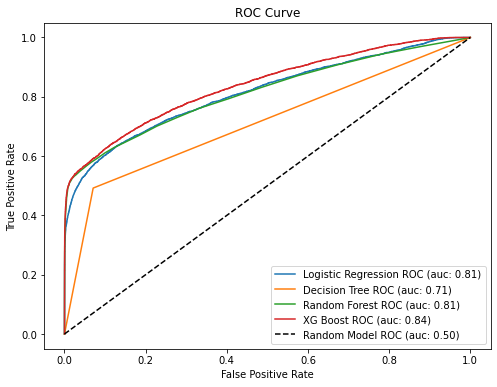

In [26]:
plt.figure(figsize = (8,6))
for mod in results:
    plt.plot(results[mod]['fpr'], results[mod]['tpr'], label='%s ROC (auc: %.2f)' %(mod, results[mod]['auc']))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label = 'Random Model ROC (auc: 0.50)')
plt.legend(loc = 'lower right')

In [27]:
## Precision-recall curves

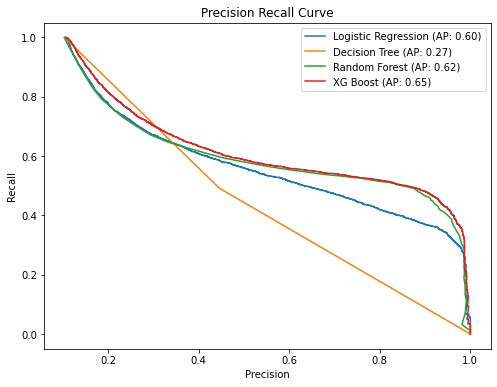

In [28]:
plt.figure(figsize = (8,6))
for mod in results:
    prec, rec, thresh = precision_recall_curve(y_val, results[mod]['pred'])
    ap = average_precision_score(y_val, results[mod]['pred'])
    plt.plot(prec, rec, label='%s (AP: %.2f)' %(mod, ap))
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision Recall Curve')
plt.legend(loc = 'upper right')

In [29]:
## Individual precision, recall, sensitivity, specificity

In [30]:
## Precision

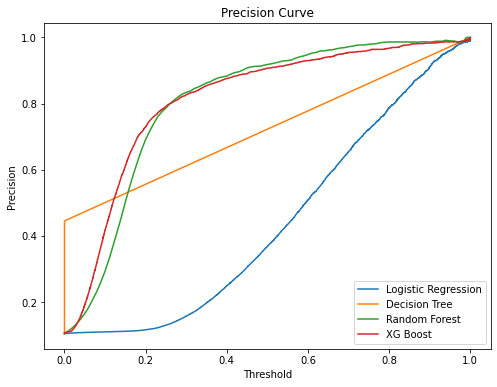

In [69]:
plt.figure(figsize = (8,6))
for mod in results:
    prec, rec, thresh = precision_recall_curve(y_val, results[mod]['pred'])
    plt.plot(np.append(0, thresh), prec, label='%s' %mod)
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title('Precision Curve')
plt.legend(loc = 'lower right')

In [35]:
## Recall

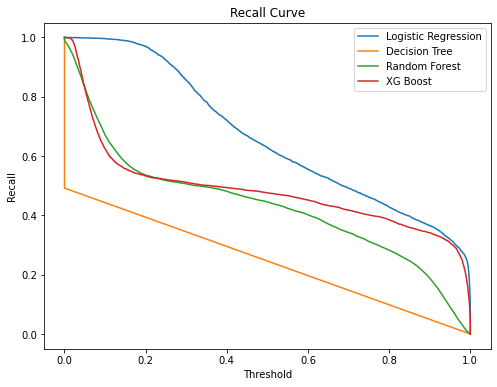

In [71]:
plt.figure(figsize = (8,6))
for mod in results:
    prec, rec, thresh = precision_recall_curve(y_val, results[mod]['pred'])
    plt.plot(np.append(0, thresh), rec, label='%s' %mod)
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.title('Recall Curve')
plt.legend(loc = 'upper right')

In [37]:
## Sensitivity

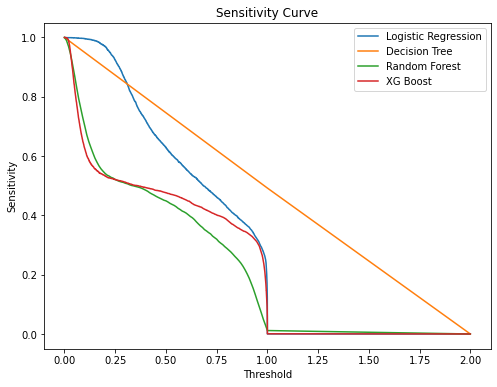

In [78]:
plt.figure(figsize = (8,6))
for mod in results:
    fpr, tpr, thresh = roc_curve(y_val, results[mod]['pred'])
    plt.plot(thresh, tpr, label='%s' %mod)
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity Curve')
plt.legend(loc = 'upper right')

In [40]:
## Specificity

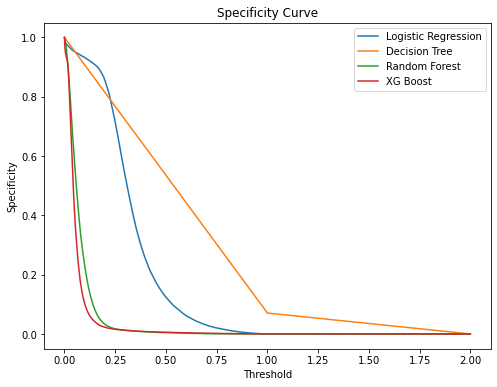

In [74]:
plt.figure(figsize = (8,6))
for mod in results:
    fpr, tpr, thresh = roc_curve(y_val, results[mod]['pred'])
    plt.plot(thresh, fpr, label='%s' %mod)
    plt.xlabel('Threshold')
    plt.ylabel('Specificity')
    plt.title('Specificity Curve')
plt.legend(loc = 'upper right')

In [42]:
## F-scores

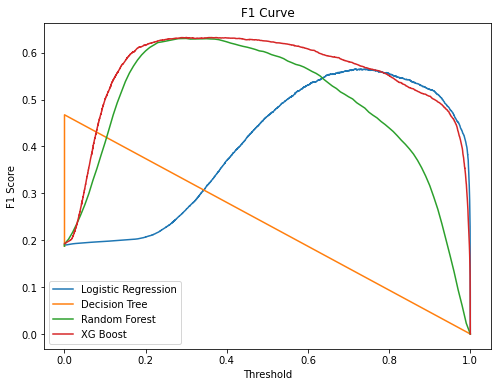

In [79]:
plt.figure(figsize = (8,6))
for mod in results:
    prec, rec, thresh = precision_recall_curve(y_val, results[mod]['pred'])
    f1 = 2 * (prec * rec) / (prec + rec)
    plt.plot(np.append(0, thresh), f1, label='%s' %mod)
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Curve')
plt.legend(loc = 'lower left')

In [45]:
## Sensitivity vs. specificity across different thresholds

In [47]:
## Waterfall plot

<BarContainer object of 50096 artists>

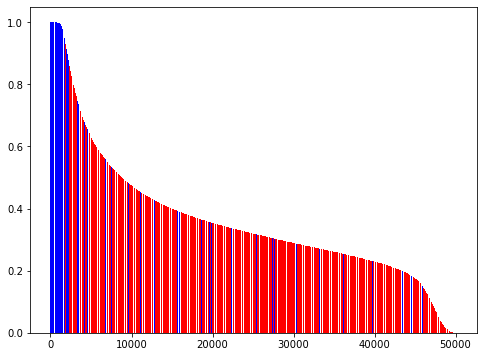

In [81]:
x = np.arange(len(lr_pred))

sort_idx = np.argsort(-lr_pred)
y = lr_pred[sort_idx]

y_col = y_val.iloc[sort_idx]
y_col = np.where(y_col==1, "blue", "red")

plt.figure(figsize = (8,6))
plt.bar(x, y, color = y_col)

In [54]:
## Clinical intuition--how much improvement in admission predictions is there relative to the original data?

In [55]:
## "Doctor model" correctness
1 - y_val.sum()/len(y_val)

0.8966783775151709

In [56]:
## Best (XGBoost) model correctness

In [57]:
bst_pred01 = bst_mod.predict(X_val)

In [58]:
(bst_pred01 == y_val).sum()/len(y_val)

0.9408335994889812

In [59]:
## Proportion of patients retained who didn't need it (XGBoost)

In [60]:
((bst_pred01==1) & (y_val==0)).sum()/len(y_val)

0.005030341743851805

In [61]:
## Proportion of patients sent home who needed to be readmitted (XGBoost)

In [62]:
((bst_pred01==0) & (y_val==1)).sum()/len(y_val)

0.05413605876716704

In [63]:
## Proprotion of patients correctly retained by "Best" model relative to "Doctor model"

In [64]:
y_val.sum()/len(y_val) - ((bst_pred01==0) & (y_val==1)).sum()/len(y_val)

0.049185563717662084